In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.transforms as mtransforms
import matplotlib.text as mtext
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

import os
import json
import pandas as pd

import sys
sys.path += ['..'] # for helper

import helper.perf_profile as pp

In [2]:
base = 'data'

In [3]:
brfs_setups = [('brfs_tensor_0.01_200_8.0_1000',8), ('brfs_tensor_0.01_200_16.0_1000',16), ('brfs_tensor_0.01_200_32.0_1000',32)]
gbfs_setups = [('gbfs_tensor_0.01_200_8.0_1000', 8), ('gbfs_tensor_0.01_200_16.0_1000', 16), ('gbfs_tensor_0.01_200_32.0_1000', 32)]
gbrfs_setups = [('gbrfs_tensor_0.01_200_8.0_1000',8), ('gbrfs_tensor_0.01_200_16.0_1000',16), ('gbrfs_tensor_0.01_200_32.0_1000',32)]
ggbfs_setups = [('ggbfs_tensor_0.01_200_8.0_1000', 8), ('ggbfs_tensor_0.01_200_16.0_1000', 16), ('ggbfs_tensor_0.01_200_32.0_1000', 32)]

syclop_setups = [('syclops_cartesian_0.01_200_8.0_60.0', 8), ('syclops_cartesian_0.01_200_16.0_60.0', 16), ('syclops_cartesian_0.01_200_32.0_60.0', 32)]

# 2LP Results Processing

In [4]:
two_lp_df = {
    'S': [],
    'algorithm' : [],
    'instance' : [],
    'trial' : [],
    'iteration': [],
    'signal': [],
    'total_time' : [],
    'disc_num_calls': [], 
    'disc_runtime': [], 
    'disc_gen': [], 
    'disc_exp' : [], 
    'cont_num_calls': [],
    'cont_runtime': [],
    'failures': [],
    'terminal_costs': [],
    'gap' : [],
    'sol_cost': [],
    'sol_steps': [],
    'sol_duration': []
}

In [5]:
def process_setups(setups, algo_name, output_df):
    for setup, S in setups:
        algorithm = algo_name
        for inst_idx in range(1,21):
            instance = 'small_{:03d}'.format(inst_idx)
            for trial_idx in range(20):
                trial = '{:02d}'.format(trial_idx)
                instance_base = os.path.join(base, setup, instance, trial)
                for iteration in range(0, 10):
                    log_file = 'two_lp.search_tree.{}.data'.format(iteration)
                    log_file = os.path.join(instance_base, log_file)
                    #print(log_file)
                    if not os.path.exists(log_file): 
                        #print("Could not find file!")
                        break
                iteration -= 1
                if iteration < 0:
                    with open(stats_file) as instream:
                        run_stats = json.loads(instream.read())
                    output_df['signal'] += [run_stats['signal']]
                    output_df['S'] += [S]
                    output_df['algorithm'] += [algorithm]
                    output_df['instance'] += [inst_idx]
                    output_df['trial'] += [trial_idx]
                    output_df['iteration'] += [iteration]
                    output_df['total_time'] += [run_stats['time']]
                    
                    output_df['disc_num_calls'] += [None]
                    output_df['disc_runtime'] += [None]
                    output_df['disc_gen'] += [None]
                    output_df['disc_exp'] += [None]
                    output_df['cont_num_calls'] += [None]
                    output_df['cont_runtime'] += [None]
                    output_df['failures'] += [None]
                    output_df['sol_cost'] += [None]
                    output_df['sol_steps'] += [None]
                    output_df['sol_duration'] += [None]
                    output_df['terminal_costs'] += [None]
                    output_df['gap'] += [1.0]        
                    continue
                search_tree = None 
                log_file = 'two_lp.search_tree.{}.data'.format(iteration)
                log_file = os.path.join(instance_base, log_file)
                with open(log_file) as inputstream:
                    buffer = inputstream.read()
                    try:
                        search_tree = json.loads(buffer)
                    except json.JSONDecodeError:
                        iteration -= 1
                        if iteration < 0:
                            with open(stats_file) as instream:
                                run_stats = json.loads(instream.read())
                            output_df['signal'] += [run_stats['signal']]
                            output_df['S'] += [S]
                            output_df['algorithm'] += [algorithm]
                            output_df['instance'] += [inst_idx]
                            output_df['trial'] += [trial_idx]
                            output_df['iteration'] += [iteration]
                            output_df['total_time'] += [run_stats['time']]

                            output_df['disc_num_calls'] += [None]
                            output_df['disc_runtime'] += [None]
                            output_df['disc_gen'] += [None]
                            output_df['disc_exp'] += [None]
                            output_df['cont_num_calls'] += [None]
                            output_df['cont_runtime'] += [None]
                            output_df['failures'] += [None]
                            output_df['sol_cost'] += [None]
                            output_df['sol_steps'] += [None]
                            output_df['sol_duration'] += [None]
                            output_df['terminal_costs'] += [None]
                            output_df['gap'] += [1.0]    
                            continue
                        log_file = 'two_lp.search_tree.{}.data'.format(iteration)
                        log_file = os.path.join(instance_base, log_file)
                        with open(log_file) as inputstream:
                            buffer = inputstream.read()
                            search_tree = json.loads(buffer)
                stats_file = os.path.join(instance_base, 'run_data.json')
                with open(stats_file) as instream:
                    run_stats = json.loads(instream.read())
                output_df['signal'] += [run_stats['signal']]
                output_df['S'] += [S]
                output_df['algorithm'] += [algorithm]
                output_df['instance'] += [inst_idx]
                output_df['trial'] += [trial_idx]
                output_df['iteration'] += [iteration]
                stats = search_tree['statistics']
                output_df['total_time'] += [stats['runtime']]
                x0_term = stats['terminal_x0']
                disc_stats = stats['discrete']

                output_df['disc_num_calls'] += [disc_stats['num_calls']]
                output_df['disc_runtime'] += [disc_stats['runtime']]
                output_df['disc_gen'] += [disc_stats['generated']]
                output_df['disc_exp'] += [disc_stats['expanded']]
                cont_stats = stats['steering']
                output_df['cont_num_calls'] += [cont_stats['num_calls']]
                output_df['cont_runtime'] += [cont_stats['runtime']]
                output_df['failures'] += [cont_stats['failures']]
                output_df['sol_cost'] += [search_tree['solution']['cost']]
                output_df['sol_steps'] += [search_tree['solution']['steps']]
                output_df['sol_duration'] += [search_tree['solution']['steps']*0.01]
                output_df['terminal_costs'] += [np.min(stats['terminal_costs'])]
                output_df['gap'] += [np.min(stats['terminal_costs'])/x0_term]

In [6]:
process_setups(brfs_setups, 'brfs', two_lp_df)
process_setups(gbrfs_setups, 'gbrfs', two_lp_df)
process_setups(gbfs_setups, 'gbfs', two_lp_df)
process_setups(ggbfs_setups, 'ggbfs', two_lp_df)

In [7]:
two_lp_df = pd.DataFrame(two_lp_df)

For each planner, the following data is available:

 - $S$: the value of the maximal triangle perimeter for CGAL's implementation of the constrained Delaunay triangulation
 - `algorithm`: planner setup identifier
 - `instance`: scenario identifier
 - `trial`: index of trial
 - `iteration`: last iteration before time out
 - `signal`: return signal, `38912` indicates that planner was interrupted by timer set
 - `total_time`: total run time measure in milliseconds
 - `disc_num_calls`: number of calls to the discrete planner
 - `disc_runtime`: total runtime accrued by all calls to discrete planner (in milliseconds)
 - `disc_gen`: total number of search nodes in the discrete planner search tree
 - `disc_exp`: total number of search nodes expanded by the discrete planner search
 - `cont_num_calls`: number of calls to DDP
 - `cont_runtime`: total runtime accrued by DDP
 - `failures`: number of times a discrete plan failed
 - `terminal_costs`: terminal cost of the last nominal trajectory returned by $2$\textsc{LP}
 - `gap`: distance to goal ratio between $x_0$ and tip of best trajectory
 - `sol_cost`: total cost of best trajectory
 - `sol_steps`: number of states in solution trajectory
 - `sol_duration`: duration of solution trajectory

In [8]:
two_lp_df.head()

,S,algorithm,instance,trial,iteration,signal,total_time,disc_num_calls,disc_runtime,disc_gen,disc_exp,cont_num_calls,cont_runtime,failures,terminal_costs,gap,sol_cost,sol_steps,sol_duration
0,8,brfs,1,0,3,38912,42056.0,111.0,768.267,10028.0,8726.0,230.0,40909.0,84.0,0.000449,0.000033,1630.517655,2600.0,26.0
1,8,brfs,1,1,4,38912,54879.0,154.0,1202.372,15781.0,13875.0,320.0,53164.0,111.0,0.000449,0.000033,1630.517655,2600.0,26.0
2,8,brfs,1,2,4,38912,55017.0,154.0,1208.086,15781.0,13875.0,320.0,53290.0,111.0,0.000449,0.000033,1630.517655,2600.0,26.0
3,8,brfs,1,3,3,38912,43961.0,111.0,781.424,10028.0,8726.0,230.0,42790.0,84.0,0.000449,0.000033,1630.517655,2600.0,26.0
4,8,brfs,1,4,3,38912,40616.0,111.0,767.752,10028.0,8726.0,230.0,39476.0,84.0,0.000449,0.000033,1630.517655,2600.0,26.0


# Syclop Results Processing

In [9]:
syclop_df = {
    'S': [],
    'algorithm' : [],
    'instance' : [],
    'trial' : [],
    'signal' : [],
    'total_time' : [],
    'terminal_costs': [],
    'gap' : [],
    'sol_cost': [],
    'sol_steps': [],
    'sol_duration': []
}

In [10]:
for setup, S in syclop_setups:
    algorithm = 'syclop'
    for inst_idx in range(1,21):
        instance = 'small_{:03d}'.format(inst_idx)
        for trial_idx in range(20):
            trial = '{:02d}'.format(trial_idx)
            instance_base = os.path.join(base, setup, instance, trial)
            run_data = None 
            log_file = 'syclops.data'
            log_file = os.path.join(instance_base, log_file)
            if not os.path.exists(log_file): 
                break
            with open(log_file) as inputstream:
                buffer = inputstream.read()
                try:
                    run_data = json.loads(buffer)
                except json.JSONDecodeError:
                    syclop_df['S'] += [S]
                    syclop_df['algorithm'] += [algorithm]
                    syclop_df['instance'] += [inst_idx]
                    syclop_df['trial'] += [trial_idx]

                    stats_file = os.path.join(instance_base, 'run_data.json')
                    with open(stats_file) as instream:
                        stats = json.loads(instream.read())
                    syclop_df['signal'] += [stats['signal']]
                    syclop_df['total_time'] += [stats['time']]

                    
                    syclop_df['sol_cost'] += [None]
                    syclop_df['sol_steps'] += [None]
                    syclop_df['sol_duration'] += [None]
                    syclop_df['terminal_costs'] += [None]
                    syclop_df['gap'] += [1.0]    
                    continue

            syclop_df['S'] += [S]
            syclop_df['algorithm'] += [algorithm]
            syclop_df['instance'] += [inst_idx]
            syclop_df['trial'] += [trial_idx]

            stats_file = os.path.join(instance_base, 'run_data.json')
            with open(stats_file) as instream:
                stats = json.loads(instream.read())
            syclop_df['signal'] += [stats['signal']]
            syclop_df['total_time'] += [stats['time']*1000.]
            
            x0_term = run_data['solution']['terminal_x0']
            syclop_df['sol_cost'] += [run_data['solution']['cost']]
            syclop_df['sol_steps'] += [run_data['solution']['steps']]
            syclop_df['sol_duration'] += [run_data['solution']['steps']*0.1]
            syclop_df['terminal_costs'] += [run_data['solution']['terminal_cost']]
            syclop_df['gap'] += [run_data['solution']['terminal_cost']/x0_term]

In [11]:
syclop_df = pd.DataFrame(syclop_df)

For $\mathrm{Syclop}$ we keep track of the following data:

 - $S$: the value of the maximal triangle perimeter for CGAL's implementation of the constrained Delaunay triangulation
 - `algorithm`: planner setup identifier
 - `instance`: scenario identifier
 - `trial`: index of trial
 - `iteration`: last iteration before time out
 - `signal`: return signal, `38912` indicates that planner was interrupted by timer set
 - `total_time`: total run time measured in seconds
 - `terminal_costs`: terminal cost of the last nominal trajectory returned by $2$\textsc{LP}
 - `gap`: distance to goal ratio between $x_0$ and tip of best trajectory
 - `sol_cost`: total cost of best trajectory
 - `sol_steps`: number of states in solution trajectory
 - `sol_duration`: duration of solution trajectory

In [12]:
syclop_df.head()

,S,algorithm,instance,trial,signal,total_time,terminal_costs,gap,sol_cost,sol_steps,sol_duration
0,8,syclop,1,0,0,61660.0,11.655926,0.857668,437.895124,32.0,3.2
1,8,syclop,1,1,0,62010.0,11.845638,0.871627,437.299200,31.0,3.1
2,8,syclop,1,2,0,61850.0,11.559663,0.850585,333.668190,24.0,2.4
3,8,syclop,1,3,0,62080.0,11.699749,0.860893,345.625478,25.0,2.5
4,8,syclop,1,4,0,62350.0,11.481929,0.844865,364.787896,27.0,2.7


# Planners

- $2$LP-RRT*-BRFS: $2$LP planner using BRFS as a discrete planner and DDP-RRT* for the extension heuristic
- $2$LP-RRT*-GBFS: $2$LP planner using GBFS as a discrete planner and DDP-RRT* for the extension heuristic
- $2$LP-BRFS: $2$LP planner using BRFS as a discrete planner and DDP-RRT for the extension heuristic
- $2$LP-GBFS: $2$LP planner using GBFS as a discrete planner and DDP-RRT for the extension heuristic

In [13]:
# table for mapping setup names into human-readable form
nice_names = {'brfs': '2LP-RRT*-BRFS',
             'gbfs': '2LP-RRT*-GBFS',
             'gbrfs': '2LP-BRFS',
             'ggbfs': '2LP-GBFS',
             'syclop': 'Syclop'}

# Analysis \& Comparison ($\Delta t = 0.01$)

In [14]:
selected = ['S', 'algorithm', 'instance', 'trial', 'total_time', 'disc_gen', 'disc_runtime', 'disc_num_calls', 'cont_runtime', 'sol_cost', 'gap']

In [15]:
grouping_by = ['S', 'algorithm', 'instance']

In [16]:
selected_syclop = ['S', 'algorithm', 'instance', 'trial', 'total_time', 'sol_cost', 'gap']

# S = 32, Performance Profiles

In [17]:
two_lp_groups = two_lp_df[selected].groupby(grouping_by)

In [18]:
syclop_groups = syclop_df[selected_syclop].groupby(grouping_by)

# Distance to goal

We compare the performance of the motion planners over the following index

$$
d = \frac{\ell_{T}(x)}{\ell_{T}(x_0)}
$$

where $x$ is the final configuration in an output trajectory, $x_0$ is the initial configuration and $\ell_{T}$ is the terminal cost function. $\ell_{T}$ is such that

$$
\ell_{T}(x) = 0,\,\mathrm{iff}\, x = x^{*}
$$

in words, it is only zero for the goal configuration.

In [19]:
from helper.benchmark import compute_performance_profiles, distance_to_goal

In [20]:
parameters = {'S': 32,
             'best_fn': np.argmin}

In [21]:
tau, rho, num_method, npts, data_names = compute_performance_profiles(nice_names,
                                                                     ['brfs', 'gbfs', 'gbrfs', 'ggbfs'], two_lp_groups,
                                                                     'syclop', syclop_groups, distance_to_goal, **parameters)

[20, 20, 20, 20, 20]


In [22]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

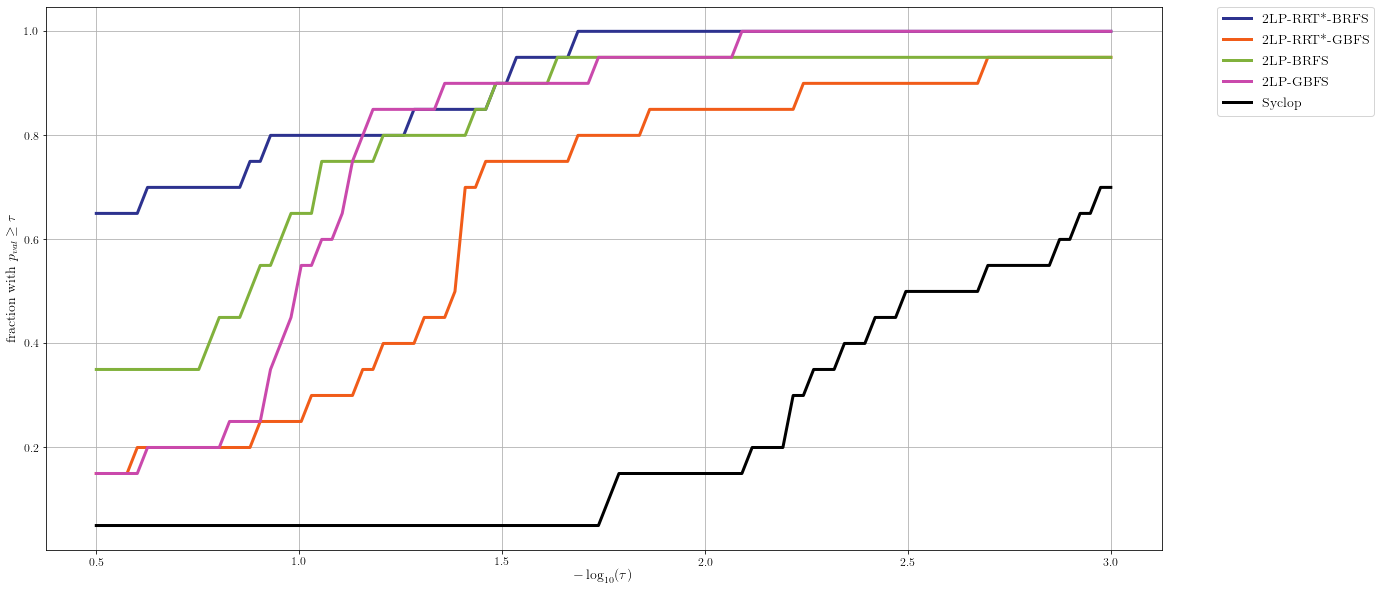

In [23]:
pp.make_plot(tau, rho, num_method, npts, data_names)

In [24]:
# make plot routine for paper
#colors = ['#2D328F', '#F15C19', "#81b13c", "#ca49ac", "000000"]

#plt.figure(figsize=(14, 9))
#for method in range(num_method):
#    plt.plot(tau, rho[:, method], color=colors[method], linewidth=2, label=data_names[method])

#plt.xlabel(r'$-\log_{10}(\tau)$')
#lt.ylabel(r'fraction with $p_{val} \geq \tau$')
#lt.legend()

#lt.grid(True)
#lt.savefig('pp_s8_dt_coarse.pdf', format='pdf', bbox_inches='tight')

# Trajectory $\tau^{*}$ Cost

In [25]:
from helper.benchmark import solution_cost

In [26]:
tau, rho, num_method, npts, data_names = compute_performance_profiles(nice_names,
                                                                     ['brfs', 'gbfs', 'gbrfs', 'ggbfs'], two_lp_groups,
                                                                     'syclop', syclop_groups, solution_cost, **parameters)

[20, 20, 20, 20, 20]


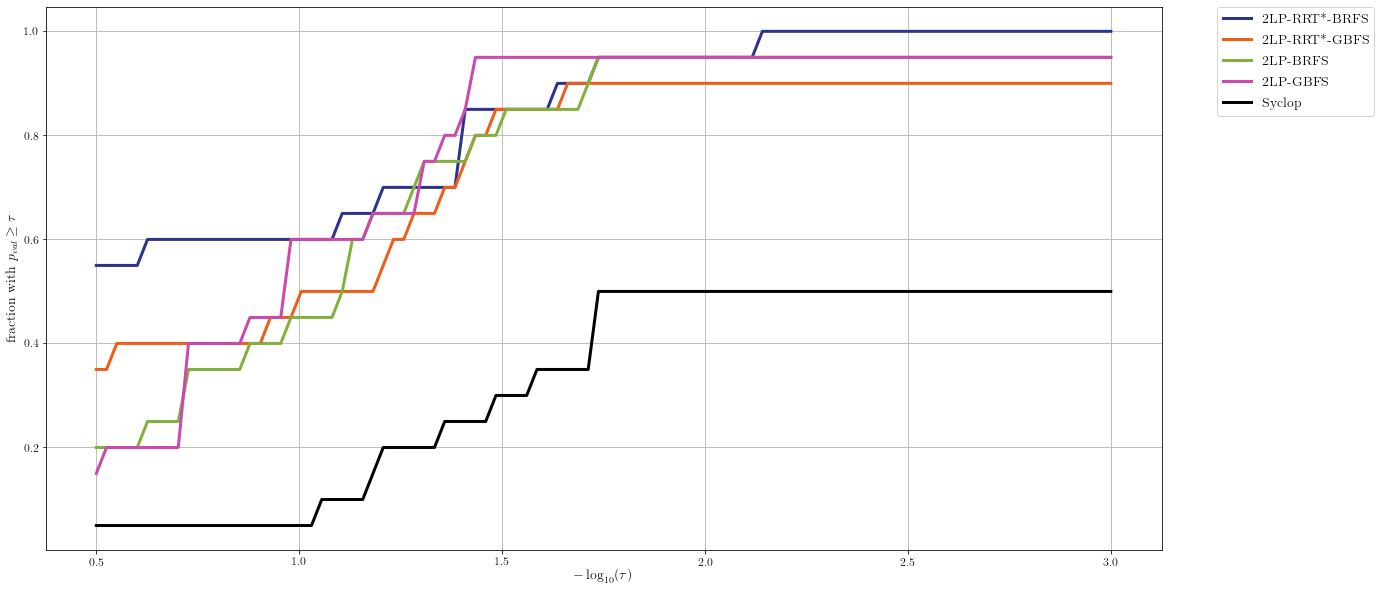

In [27]:
pp.make_plot(tau, rho, num_method, npts, data_names)

# Runtime

Time out set at 60 seconds, planner at top is fastest

In [28]:
from helper.benchmark import runtime

In [29]:
tau, rho, num_method, npts, data_names = compute_performance_profiles(nice_names,
                                                                     ['gbrfs', 'ggbfs'], two_lp_groups,
                                                                     'syclop', syclop_groups, runtime, **parameters)

[20, 20, 20]


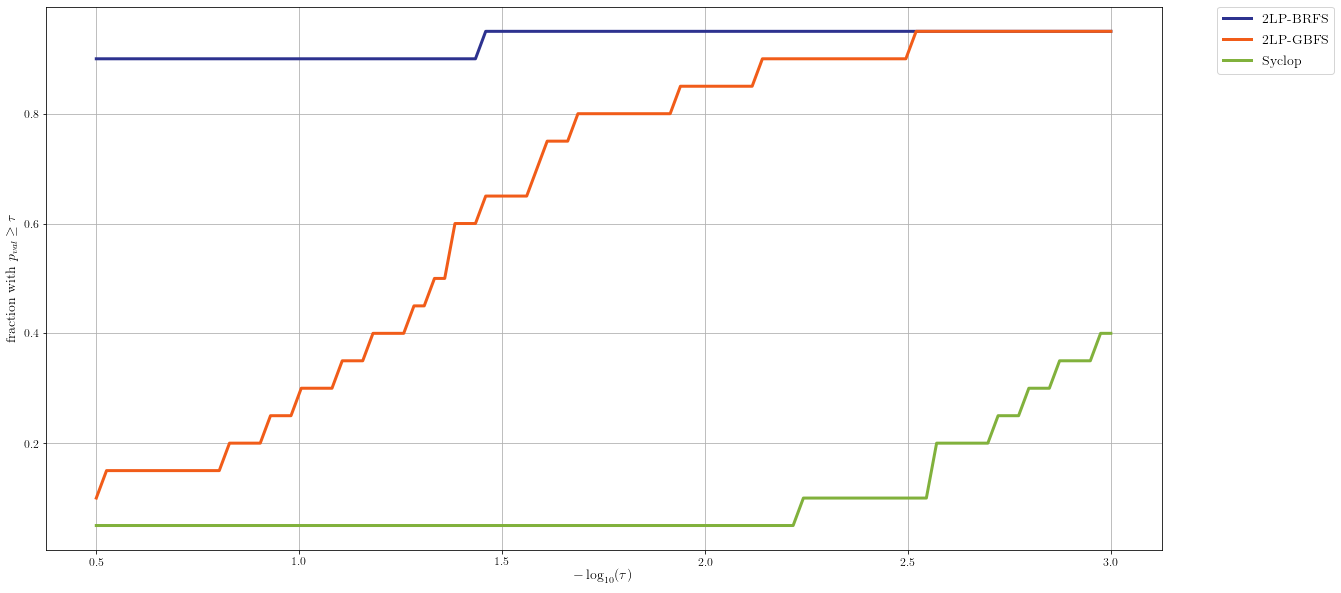

In [30]:
pp.make_plot(tau, rho, num_method, npts, data_names)

# Generated Nodes

[20, 20]


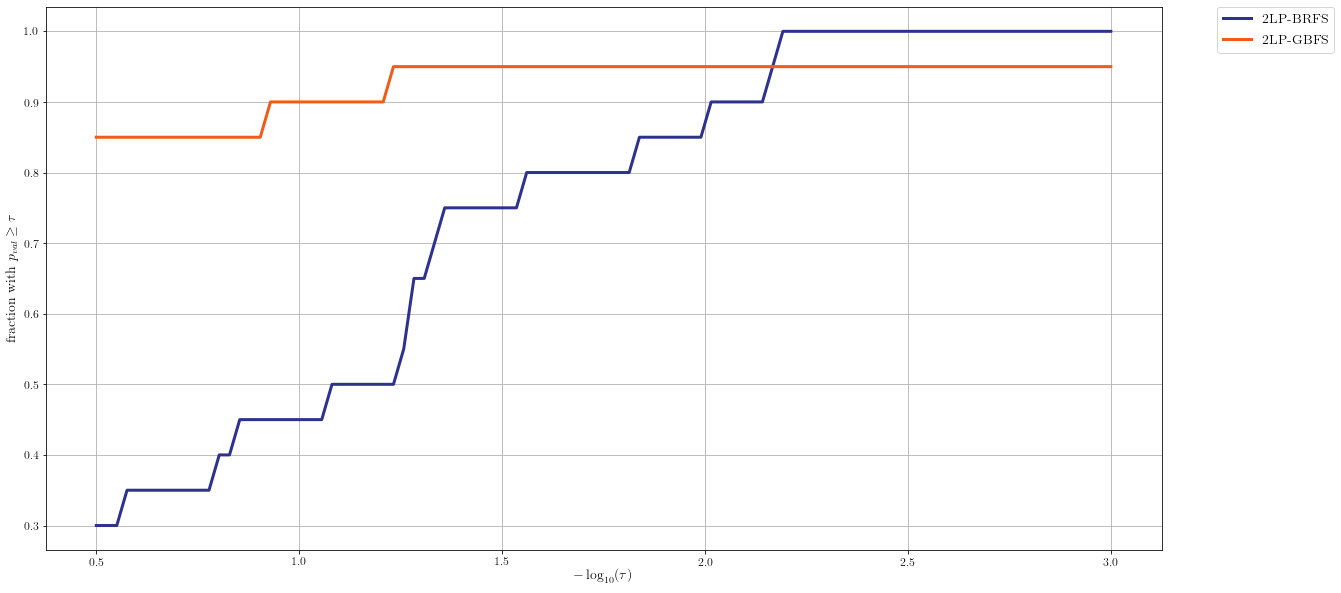

In [31]:
from helper.benchmark import generated

tau, rho, num_method, npts, data_names = compute_performance_profiles(nice_names,
                                                                     ['gbrfs', 'ggbfs'], two_lp_groups,
                                                                     None, [], generated, **parameters)
pp.make_plot(tau, rho, num_method, npts, data_names)

# Number of calls to Discrete Planner

[20, 20]


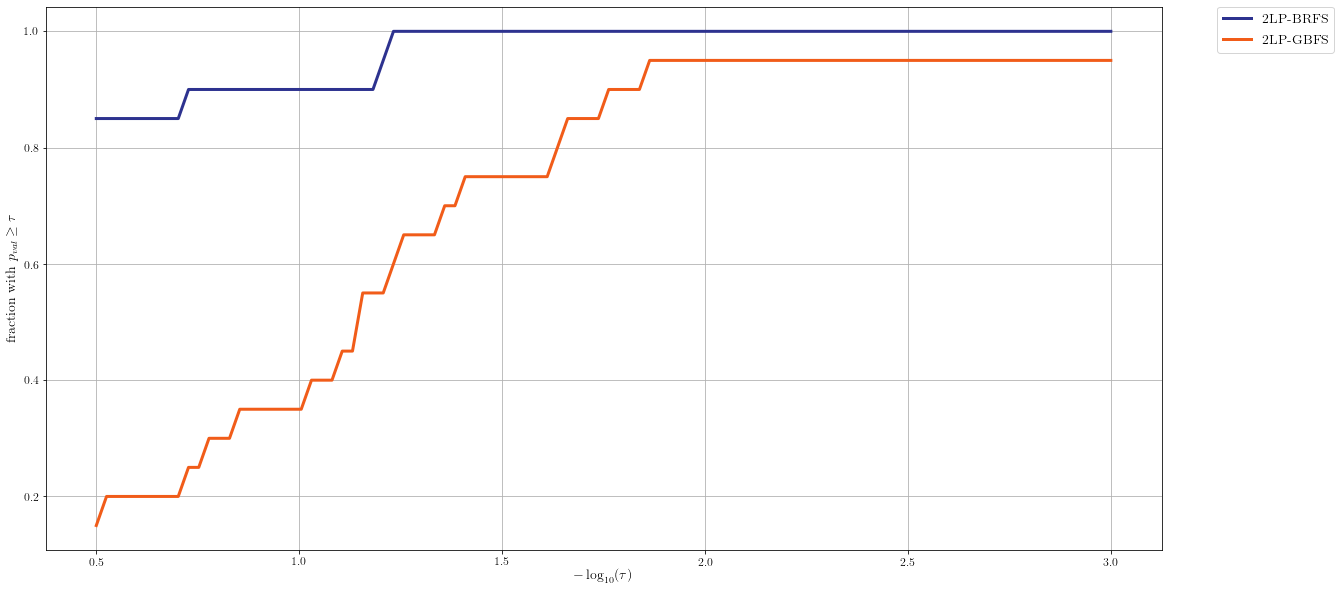

In [32]:
from helper.benchmark import disc_planner_calls

tau, rho, num_method, npts, data_names = compute_performance_profiles(nice_names,
                                                                     ['gbrfs', 'ggbfs'], two_lp_groups,
                                                                     None, [], disc_planner_calls, **parameters)
pp.make_plot(tau, rho, num_method, npts, data_names)